<a href="https://colab.research.google.com/github/julianovale/BB_Evolution/blob/main/0019_AluraBB_RedesNeurais_TreinandoRedeNeural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

Text(0, 0.5, 'color_intensity')

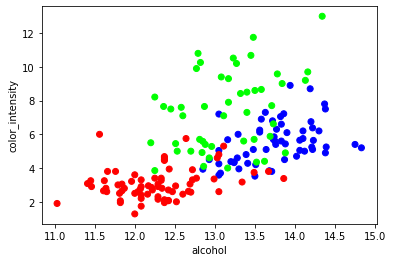

In [2]:
from sklearn import datasets
wine = datasets.load_wine()
features = [0, 9] # no exemplo vamos usar só essas duas características: teor alcoólico e intensidade da coloração

data = wine.data[:, features]
target = wine.target

plt.scatter(data[:, 0], data[:, 1], c=target, cmap=plt.cm.brg)
plt.xlabel(wine.feature_names[features[0]])
plt.ylabel(wine.feature_names[features[1]])

Text(0, 0.5, 'color_intensity')

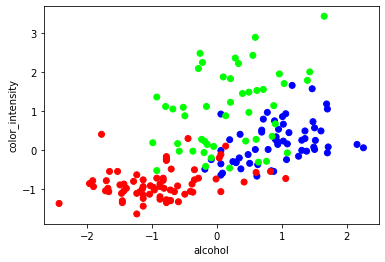

In [3]:
# normalização

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data = scaler.fit_transform(data)

plt.scatter(data[:, 0], data[:, 1], c=target, cmap=plt.cm.brg)
plt.xlabel(wine.feature_names[features[0]])
plt.ylabel(wine.feature_names[features[1]])

In [4]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print(device)

cuda


In [5]:
class WineClassifier(nn.Module):

  def __init__(self, input_size, hidden_size, out_size):
    super(WineClassifier, self).__init__()

    self.hidden = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.out = nn.Linear(hidden_size, out_size)
    self.softmax = nn.Softmax()

  def forward(self, X):

    feature = self.relu(self.hidden(X))
    output = self.softmax(self.out(feature))

    return output

input_size = data.shape[1]
hidden_size = 32
out_size = len(wine.target_names)

net = WineClassifier(input_size, hidden_size, out_size).to(device) # cast na GPU

# Função para plotar fronteira de decisão

In [6]:
def plot_boundary(X, y, model):
  x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
  y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1
  
  spacing = min(x_max - x_min, y_max - y_min) / 100
  
  XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing),
                       np.arange(y_min, y_max, spacing))
  
  data = np.hstack((XX.ravel().reshape(-1,1), 
                    YY.ravel().reshape(-1,1)))
  
  # For binary problems
  # db_prob = model(Variable(torch.Tensor(data)).cuda() )
  # clf = np.where(db_prob.cpu().data < 0.5,0,1)
  
  # For multi-class problems
  db_prob = model(torch.Tensor(data).to(device) )
  clf = np.argmax(db_prob.cpu().data.numpy(), axis=-1)
  
  Z = clf.reshape(XX.shape)
  
  plt.contourf(XX, YY, Z, cmap=plt.cm.brg, alpha=0.5)
  plt.scatter(X[:,0], X[:,1], c=y, edgecolors='k', s=25, cmap=plt.cm.brg)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


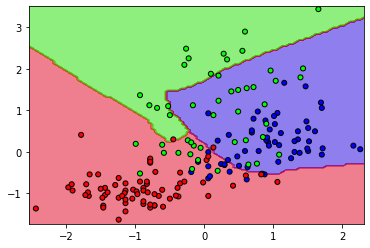

In [7]:
plot_boundary(data, target, net)

# Otimizando fronteira de decisão

In [8]:
# Função de perda (Função objetivo) 
criterion = nn.CrossEntropyLoss().to(device)

# Otimizador: Descida do gradiente
# Stochastic Gradient Descent

from torch import optim

optimizer = optim.SGD(net.parameters(), lr=1e-3) # lr = learning rate ==> 0.001

# Treinando o modelo

In [9]:
X = torch.FloatTensor(data).to(device)
Y = torch.LongTensor(target).to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


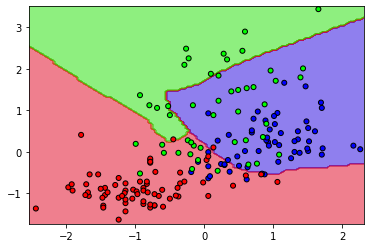

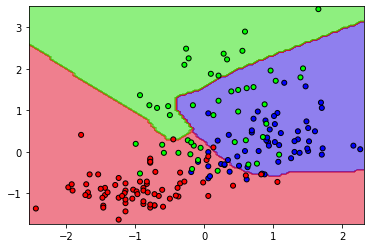

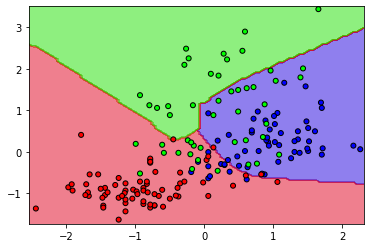

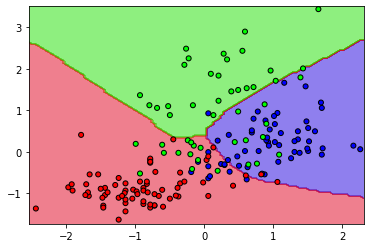

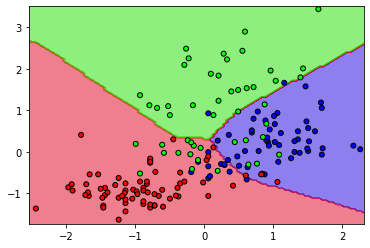

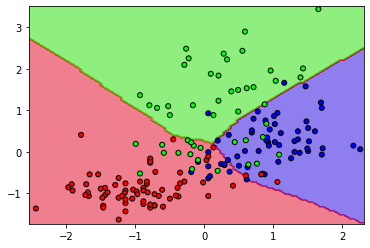

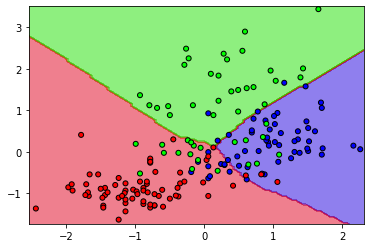

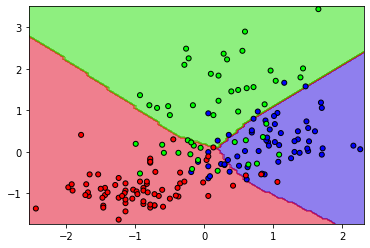

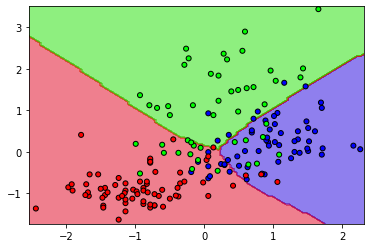

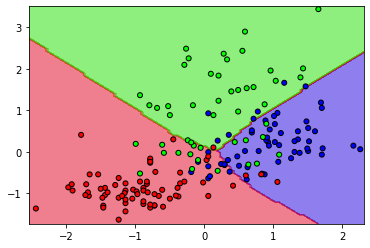

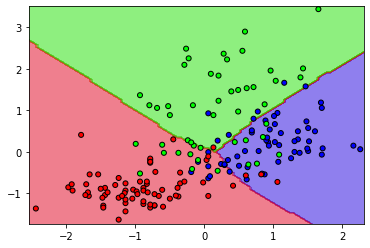

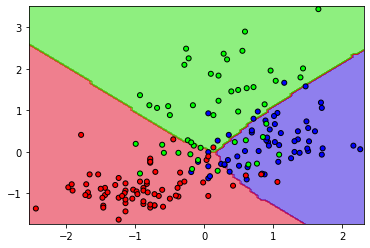

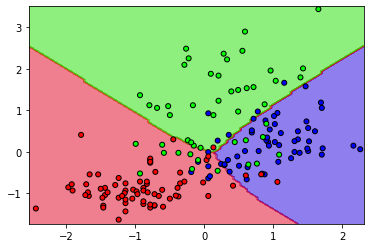

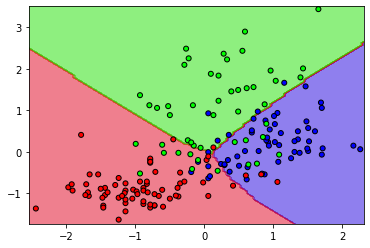

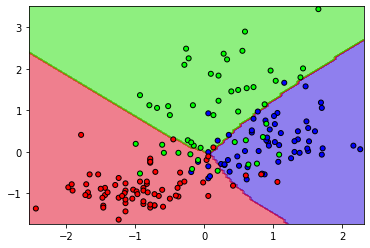

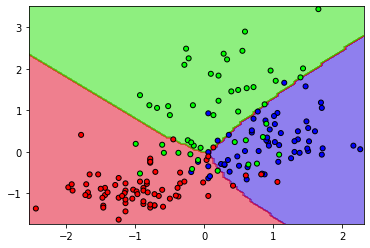

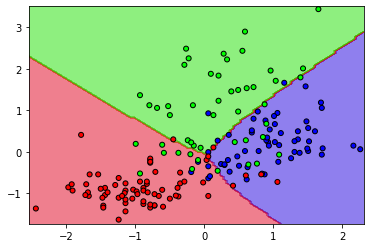

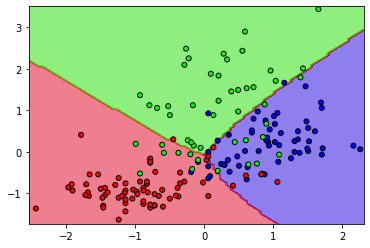

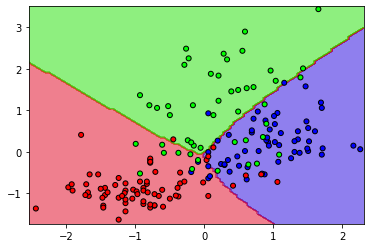

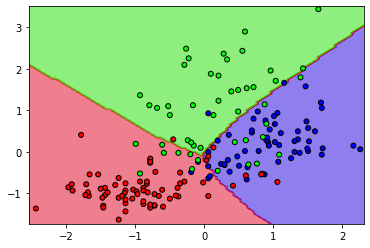

In [10]:
for i in range(200): # vou iterar 200 vezes
  # forward
  pred = net(X) # alimentar os dados
  loss = criterion(pred, Y) # calcular a função de custo

  # backpropagation
  loss.backward() # calcular o gradiente
  optimizer.step() # atualizar os pesos

  if i % 10 == 0:
    plt.figure()
    plot_boundary(data, target, net)